# Policy Gradient Methods - Actor-Critic with Eligibility Traces

**Due date : 27/03/2018**

**By : Julien Roy and David Kanaa**

In [1]:
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm import tqdm
import numpy as np
import os
import math
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction

REINFORCE is a popular Policy Gradient algorithm that allows to use neural networks to learn a policy in environments with arbitrarily large state spaces. However, it uses Monte-Carlo returns to update the parameters of the function approximator, which comes with high variance. This drawback makes the algorithm a lot of data to converge.

Actor-Critic is a method that uses two different networks, one for function approximation and the other as a policy network. This method uses temporal differences which introduce a bias but usually allow agents to learn faster. In this work, we implement an Actor-Critic algorithm using two simple MLPs to solve the popular CartPole problem from OpenAi gym. More specifically we implement the version of the algorithm that uses eligibility traces which allow to accurately control the amount of bootstrapping used by the agent.

# Implementation

##### Simple Feedforward Network (actor and critic)

In [2]:
class MLP(nn.Module):

    def __init__(self, inp_size, h_sizes, out_size, out_type, nonlinearity, init_type, name, verbose=False):

        super(MLP, self).__init__()

        self.name = name

        # Hidden layers
        self.hidden = nn.ModuleList([nn.Linear(inp_size, h_sizes[0])])
        for k in range(len(h_sizes)-1):
            self.hidden.append(nn.Linear(h_sizes[k], h_sizes[k+1]))

        # Output layer
        self.out = nn.Linear(h_sizes[-1], out_size)

        self.out_type = out_type

        # Initializes the parameters
        self.init_parameters(init_type)

        if verbose:
            print('\nModel Info ------------')
            print(self)
            print("Total number of parameters : {:.2f} k".format(self.get_number_of_params() / 1e3))
            print('---------------------- \n')

    def forward(self, x):

        # Feedforward
        for layer in self.hidden:
            a = layer(x)
            x = F.elu(a)

        if self.out_type == "distribution":
            output = F.softmax(self.out(x), dim=1)

        elif self.out_type == "real_values":
            output = self.out(x)

        return output

    def init_parameters(self, init_type):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.constant(module.bias, 0)
                if init_type == "glorot":
                    nn.init.xavier_normal(module.weight, gain=nn.init.calculate_gain("relu"))
                elif init_type == "standard":
                    stdv = 1. / math.sqrt(module.weight.size(1))
                    nn.init.uniform(module.weight, -stdv, stdv)
        for p in self.parameters():
            p.requires_grad = True

    def get_number_of_params(self):
        total_params = 0
        for params in self.parameters():
            total_size = 1
            for size in params.size():
                total_size *= size
            total_params += total_size
        return total_params

    def name(self):
        return self.name

##### Training procedure for Actor-Critic algorithm with eligibility traces

In [8]:
def train_actor_critic(actor, critic, env, config, verbose):

    critic_optimizer = _optim(critic.parameters(), lr=config['alpha_critic'])
    actor_optimizer  = _optim(actor.parameters(), lr=config['alpha_actor'])


    episode_lengths = []
    for n in range(config['max_episodes']):
        # initialise S (select a starting state for the episode)
        state = env.reset()
        # to torch.autograd.Variable
        state = Variable(torch.Tensor([state]))

        #
        critic_eligibilities = dict()
        actor_eligibilities  = dict()
        I = 1

        # initialise critic eligibilities ([re]set to zero(0))
        for i, group in enumerate(critic_optimizer.param_groups):
            zs = dict()
            for p in group["params"]:
                zs[p] = torch.zeros_like(p.data)
            critic_eligibilities[i] = zs

        # initialise actor eligibilities ([re]set to zero(0))
        for i, group in enumerate(actor_optimizer.param_groups):
            zs = dict()
            for p in group["params"]:
                zs[p] = torch.zeros_like(p.data)
            actor_eligibilities[i] = zs

        total_rewards = 0
        done = False
        t = 0
        
        # UNTIL TERMINATION
        while not done and t < 200:       
            
            # samples an action from the actor's output distribution
            probas = actor(state)
            action = int(probas.multinomial().data)
            
            # take action A and observe next state S' and reward R
            observation, reward, done, _ = env.step(action)
            total_rewards += reward
            observation = Variable(torch.Tensor([observation]))        
            
            # compute TD error (if S' is terminal, then v(S', w)=0)
            error = reward + (config['gamma'] * critic(observation)) - critic(state) # if not done else reward - critic(state)
            _delta = error.cpu().data

            # let the critic evaluates the state and compute its gradient by backpropagation
            v = critic(state)
            v.backward()
            
            # update critic's parameters  
            for i, group in enumerate(critic_optimizer.param_groups):

                for p in group["params"]:
                    if p.grad is None:
                        continue
                    # retrieve current eligibility
                    z = critic_eligibilities[i][p]
                    # retrieve current gradient
                    grad = p.grad.data
                    # update eligibility
                    #
                    # torch.nn.utils.clip_grad_norm(critic.parameters(), 1.0)
                    z.mul_(config['gamma'] * config['lambda_critic']).add_(I, grad)
                    # update parameters
                    p.data.add_(config['alpha_critic'] * _delta * z)
                    # reset gradients
                    p.grad.detach_()
                    p.grad.zero_()

            # computes the gradient for the actor
            probas = actor(state)
            log_proba = torch.log(probas)[:, action]
            log_proba.backward()
            
            # update actor's parameters     
            for i, group in enumerate(actor_optimizer.param_groups):

                for p in group["params"]:
                    if p.grad is None:
                        continue
                    # retrieve current eligibility
                    z = actor_eligibilities[i][p]
                    # retrieve current gradient
                    grad = p.grad.data
                    # update eligibility
                    #
                    # torch.nn.utils.clip_grad_norm(actor.parameters(), 1.0)
                    z.mul_(config['gamma'] * config['lambda_actor']).add_(I, grad)
                    # update parameters
                    p.data.add_(config['alpha_actor'] * _delta * z)
                    # reset gradients
                    p.grad.detach_()
                    p.grad.zero_()

            I = config['gamma'] * I
            t = t + 1
            
            # update current state to next state (S = S')
            state = observation
        
        if verbose:
            print("episode {}, {} steps.".format(n+1, t+1))
        episode_lengths.append(total_rewards)
    
    env.close()
    
    return episode_lengths

# Experiments

In [5]:
def running_average(array):
    mean = 0
    new_array = []
    for element in array:
        mean = 0.8 * mean + 0.2 * element
        new_array.append(mean)
    return new_array

### Actor($\lambda$)-Critic($\lambda$)   v.s.   Actor-Critic($\lambda$)   v.s.  Actor-Critic

In [4]:
config = {}
config['max_episodes'] = 500
config['gamma'] = 0.99
config['alpha_critic'] = 1e-5
config['alpha_actor'] = 1e-3
_optim = torch.optim.SGD
seed = 1234

In [5]:
config['lambda_critic'] = 0.9
config['lambda_actor'] = 0.9

env = gym.make('CartPole-v1')
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

actor = MLP(len(env.observation_space.sample()), [128], env.action_space.n, "distribution", "relu", "standard", "actor", verbose=False)
critic = MLP(len(env.observation_space.sample()), [128], 1, "real_values", "relu", "standard", "critic", verbose=False)
episode_lengths_scheme0 = train_actor_critic(actor, critic, env, config, verbose=False)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\julro\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
C:\Users\julro\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.59it/s]


In [6]:
config['lambda_critic'] = 0.99
config['lambda_actor'] = 0.

env = gym.make('CartPole-v1')
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

actor = MLP(len(env.observation_space.sample()), [128], env.action_space.n, "distribution", "relu", "standard", "actor", verbose=False)
critic = MLP(len(env.observation_space.sample()), [128], 1, "real_values", "relu", "standard", "critic", verbose=False)
episode_lengths_scheme1 = train_actor_critic(actor, critic, env, config, verbose=False)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\julro\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
C:\Users\julro\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 109.60it/s]


In [7]:
config['lambda_critic'] = 0.
config['lambda_actor'] = 0.

env = gym.make('CartPole-v1')
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

actor = MLP(len(env.observation_space.sample()), [128], env.action_space.n, "distribution", "relu", "standard", "actor", verbose=False)
critic = MLP(len(env.observation_space.sample()), [128], 1, "real_values", "relu", "standard", "critic", verbose=False)
episode_lengths_scheme2 = train_actor_critic(actor, critic, env, config, verbose=False)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\julro\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
C:\Users\julro\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 97.36it/s]


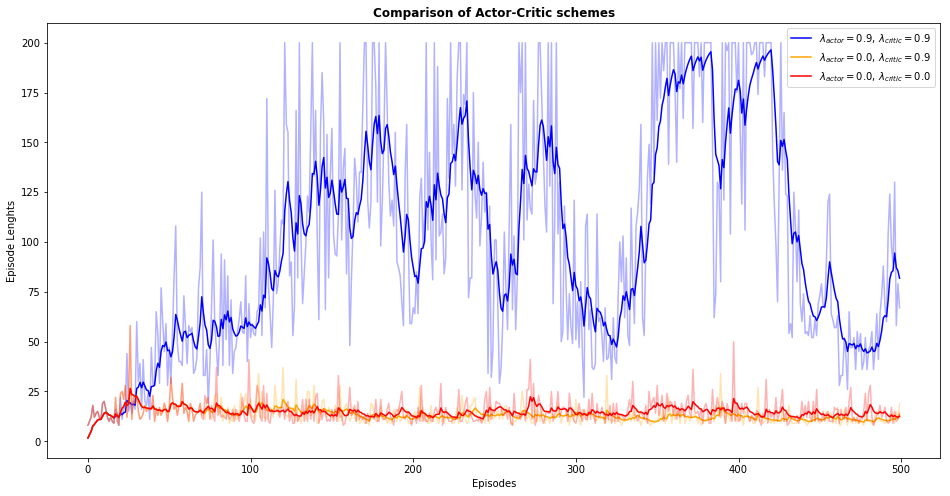

In [26]:
%matplotlib inline
plt.figure(figsize=(16, 8))

plt.title("Comparison of Actor-Critic schemes", fontweight='bold')
plt.plot(episode_lengths_scheme0, color="blue", alpha=0.3)
plt.plot(running_average(episode_lengths_scheme0), color="blue", label="$\lambda_{actor} = 0.9$, $\lambda_{critic} = 0.9$")
plt.plot(episode_lengths_scheme1, color="orange", alpha=0.3)
plt.plot(running_average(episode_lengths_scheme1), color="orange", label="$\lambda_{actor} = 0.0$, $\lambda_{critic} = 0.9$")
plt.plot(episode_lengths_scheme2, color="red", alpha=0.3)
plt.plot(running_average(episode_lengths_scheme2), color="red", label="$\lambda_{actor} = 0.0$, $\lambda_{critic} = 0.0$")
plt.xlabel("Episodes")
plt.ylabel("Episode Lenghts")
plt.legend(loc='best')

plt.show()

### Hyperparameter study for $\gamma$ and $\lambda$

###### For Actor($\lambda$)-Critic($\lambda$) 

C:\Users\julro\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
C:\Users\julro\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.


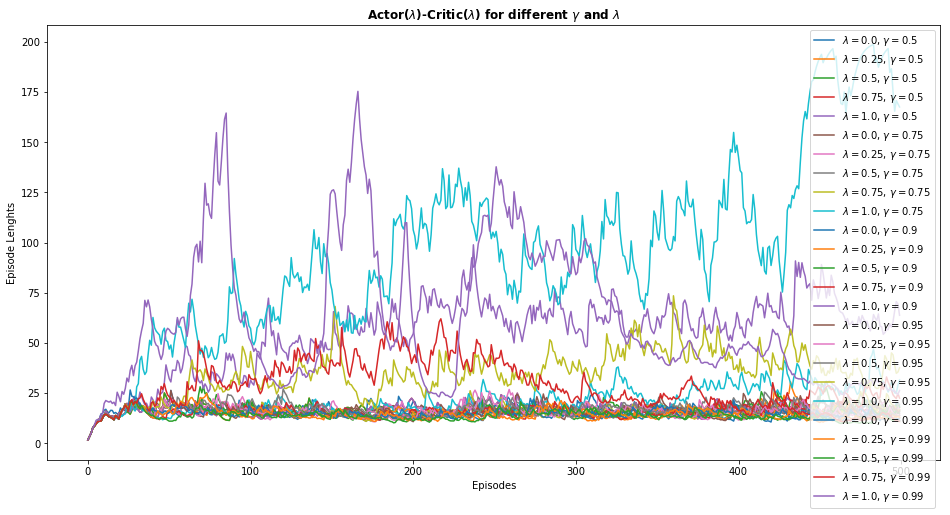

In [10]:
config = {}
config['max_episodes'] = 500
config['alpha_critic'] = 1e-5
config['alpha_actor'] = 1e-3
_optim = torch.optim.SGD
seed = 1234

%matplotlib inline
plt.figure(figsize=(16, 8))

for gamma in [0.5, 0.75, 0.9, 0.95, 0.99]:
    for lamda in [0., 0.25, 0.50, 0.75, 1.]:
        
        config['gamma'] = gamma
        config['lambda_critic'] = lamda
        config['lambda_actor'] = lamda

        env = gym.make('CartPole-v1')
        env.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)

        actor = MLP(len(env.observation_space.sample()), [128], env.action_space.n, "distribution", "relu", "standard", "actor", verbose=False)
        critic = MLP(len(env.observation_space.sample()), [128], 1, "real_values", "relu", "standard", "critic", verbose=False)
        episode_lengths_scheme0 = train_actor_critic(actor, critic, env, config, verbose=False)
        
        plt.plot(running_average(episode_lengths_scheme0), label="$\lambda = ${}, $\gamma = ${}".format(lamda, gamma))

plt.title("Actor($\lambda$)-Critic($\lambda$) for different $\gamma$ and $\lambda$", fontweight='bold')
plt.xlabel("Episodes")
plt.ylabel("Episode Lenghts")
plt.legend(loc='best')
plt.show()

###### For Actor-Critic($\lambda$) 

C:\Users\julro\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
C:\Users\julro\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.


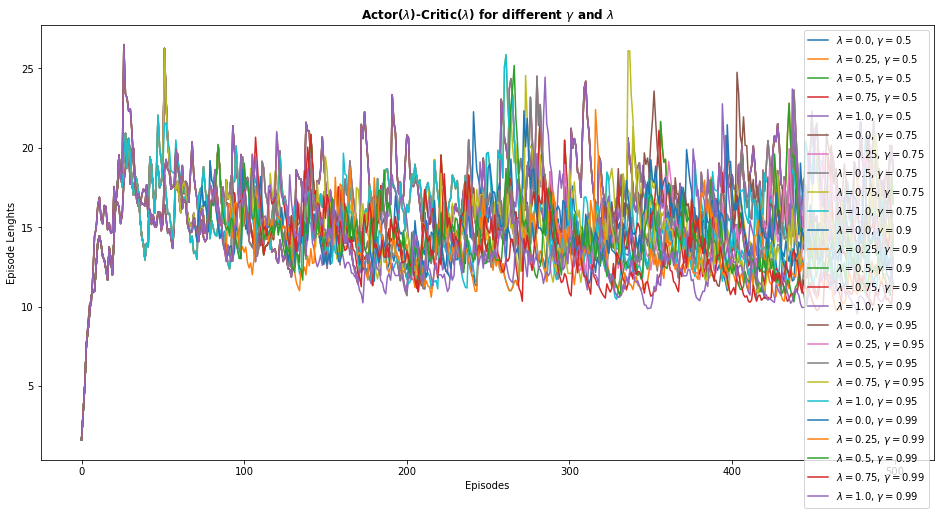

In [11]:
config = {}
config['max_episodes'] = 500
config['alpha_critic'] = 1e-5
config['alpha_actor'] = 1e-3
_optim = torch.optim.SGD
seed = 1234

%matplotlib inline
plt.figure(figsize=(16, 8))

for gamma in [0.5, 0.75, 0.9, 0.95, 0.99]:
    for lamda in [0., 0.25, 0.50, 0.75, 1.]:
        
        config['gamma'] = gamma
        config['lambda_critic'] = lamda
        config['lambda_actor'] = 0.

        env = gym.make('CartPole-v1')
        env.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)

        actor = MLP(len(env.observation_space.sample()), [128], env.action_space.n, "distribution", "relu", "standard", "actor", verbose=False)
        critic = MLP(len(env.observation_space.sample()), [128], 1, "real_values", "relu", "standard", "critic", verbose=False)
        episode_lengths_scheme1 = train_actor_critic(actor, critic, env, config, verbose=False)
        
        plt.plot(running_average(episode_lengths_scheme1), label="$\lambda = ${}, $\gamma = ${}".format(lamda, gamma))

plt.title("Actor-Critic($\lambda$) for different $\gamma$ and $\lambda$", fontweight='bold')
plt.xlabel("Episodes")
plt.ylabel("Episode Lenghts")
plt.legend(loc='best')
plt.show()

###### For Actor-Critic

C:\Users\julro\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
C:\Users\julro\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.


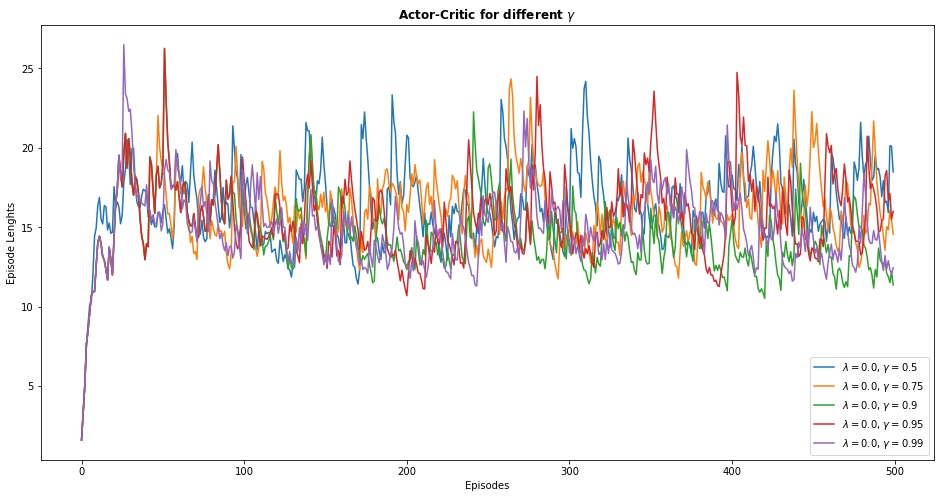

In [14]:
config = {}
config['max_episodes'] = 500
config['alpha_critic'] = 1e-5
config['alpha_actor'] = 1e-3
_optim = torch.optim.SGD
seed = 1234

%matplotlib inline
plt.figure(figsize=(16, 8))

for gamma in [0.5, 0.75, 0.9, 0.95, 0.99]:

    config['gamma'] = gamma
    config['lambda_critic'] = 0.
    config['lambda_actor'] = 0.

    env = gym.make('CartPole-v1')
    env.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

    actor = MLP(len(env.observation_space.sample()), [128], env.action_space.n, "distribution", "relu", "standard", "actor", verbose=False)
    critic = MLP(len(env.observation_space.sample()), [128], 1, "real_values", "relu", "standard", "critic", verbose=False)
    episode_lengths_scheme1 = train_actor_critic(actor, critic, env, config, verbose=False)

    plt.plot(running_average(episode_lengths_scheme1), label="$\lambda = ${}, $\gamma = ${}".format(0., gamma))

plt.title("Actor-Critic for different $\gamma$", fontweight='bold')
plt.xlabel("Episodes")
plt.ylabel("Episode Lenghts")
plt.legend(loc='best')
plt.show()

# Discussion

Our algorithm succeeds in learning to balance the pole to some extent. In the first graph, we clearly see that the Actor($\lambda$)-Critic($\lambda$) makes progress and performs almost perfectly for serveral consecutive episodes (blue curve, peaks around episode 400). However, we also note that the algorithm is quite unstable, and that it seems like it constantly risks to deteriorate given some unlucky episodes. The performance is also strongly affected by the random seed. This instability is even worse for the algorithms where $\lambda_{actor} = 0$ and when both $\lambda_{actor} = 0$ and $\lambda_{critic} = 0$. In fact, we haven't been able to make those variants learn useful parameters for this task (even by varying the size of the networks, the activation functions, the learning rates and the discount factor).

Our hyperparameter study for $\lambda$ and $\gamma$ confirms the instabilities observed for our algorithms. While Policy Gradient is known to be a challenging way to train neural networks (the gradients are a lot more noisy than for supervised learning), we also consider this level of instabilities atypical and suspect that there might be a small error in our implementation of these algorithms.

Right below, we show a comparison of 5 episodes between our agent right after initialization and our learnt agent with our default hyperparameters (curve blue of first graph). We can see that it still delivers an interesting performance!

In [2]:
%matplotlib
begin_images = sorted(os.listdir("video_ckpts_begin"), key=lambda item: (int(item.split('.')[0]), item))

fig = plt.figure(figsize=(12,8))
anim_begin_list = []
for image in begin_images:
    im = plt.imread(os.path.join("video_ckpts_begin", image))
    anim_begin = plt.imshow(im, animated=True)
    plt.axis('off')
    anim_begin_list.append([anim_begin])
    
ani1 = animation.ArtistAnimation(fig, anim_begin_list, interval=75, blit=True, repeat_delay=1000)
HTML(ani1.to_html5_video())

Using matplotlib backend: Qt5Agg


In [2]:
%matplotlib
end_images = sorted(os.listdir("video_ckpts_end"), key=lambda item: (int(item.split('.')[0]), item))

fig = plt.figure(figsize=(12,8))
anim_end_list = []
for image in end_images:
    im = plt.imread(os.path.join("video_ckpts_end", image))
    anim_end = plt.imshow(im, animated=True)
    plt.axis('off')
    anim_end_list.append([anim_end])
    
ani2 = animation.ArtistAnimation(fig, anim_end_list, interval=75, blit=True, repeat_delay=1000)
HTML(ani2.to_html5_video())

Using matplotlib backend: Qt5Agg


# Conclusion

In this assignment, we partially solved the CartPole problem. We also have a much better understanding of the mechanics of non-linear function approximation, Policy Gradient methods, the Actor-Critic framework and the mechanics of Eligibility Traces in general. We look forward to improve our implementation of this technique and learn more about methods to stabilize learning in Deep Reinforcement Learning setups.